# 색상 히스토그램(비주얼) 기반으로 Shot 나누기

- Non-Linear Consumption of Videos Using a Sequence of Personalized Multimodal Fragments (IUI 21) 메서드 참고

- opencv gpu 세팅해야 시간이 빨라짐. cpu로 하면 시간이 많이 걸림

In [7]:
import utils
import cv2

# 원하는 비디오 URL 넣기
cap = utils.openVideoStream("https://www.youtube.com/watch?v=hpXD2hwHjC8")
video_frame = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# shot_boundary_detection 실행이 끝나면 비디오 스트림이 닫힘
# 여러 파라미터 조정해가며 해보기, bins는 16 정도면 충분한 것으로 보임
shots1, diffs1 = utils.shot_boundary_detection(
    cap, scale_factor=5, bins=16, window_size=int(video_frame), resize_dim=(640, 360)
)

'https://www.youtube.com/watch?v=hpXD2hwHjC8'에서 progressive 720p 스트림 URL을 가져오는 중...
⚠️ 720p @30fps progressive 스트림 없음 → fallback으로 최대 해상도 progressive 선택
🎬 선택된 스트림: mp4 | 346p @ 30fps
URL: https://rr8---sn-n3cgv5qc5oq-bh2sr.googlevideo.com/videoplayback?expire=1753119813&ei=5Sd-aJjeLPDZ29gPpZfSkQ8&ip=163.180.118.139&id=o-AAr_2vsS-tLlOmuWKOYHPSNfj6QafBX4qE7WMVHQo_k2&itag=18&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&met=1753098213%2C&mh=Hl&mm=31%2C26&mn=sn-n3cgv5qc5oq-bh2sr%2Csn-3pm76nes&ms=au%2Conr&mv=m&mvi=8&pl=19&rms=au%2Cau&initcwndbps=6780000&bui=AY1jyLOEZeB1TJmwqqaQhiIyNd1pNjG7e7Di_82XrJOGodeW8-8a692H-T538WMiVwlWgmVFuDlCOno8&vprv=1&svpuc=1&mime=video%2Fmp4&ns=DHc25SH5_YFIAitc0Ehyf30Q&rqh=1&cnr=14&ratebypass=yes&dur=277.966&lmt=1736034760502531&mt=1753097841&fvip=3&lmw=1&fexp=51543007&c=TVHTML5&sefc=1&txp=4538434&n=KrVAZBuX1gUI8A&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cbui%2Cvprv%2Csvpuc%2Cmime%2Cns%2Crqh%2Ccnr%2Cratebypass%2Cdur%2Clmt&lsparams=met

프레임 처리 중: 100%|██████████| 8336/8336 [00:15<00:00, 528.88it/s, 프레임=8336, 차이=0.0375, 임계값=0.1344, 샷 경계=X]


샷 경계 감지 완료. 총 52개의 샷 경계 감지됨.


In [11]:
shots1 = utils.sum_short_boundaries(shots1)
len(shots1)

50

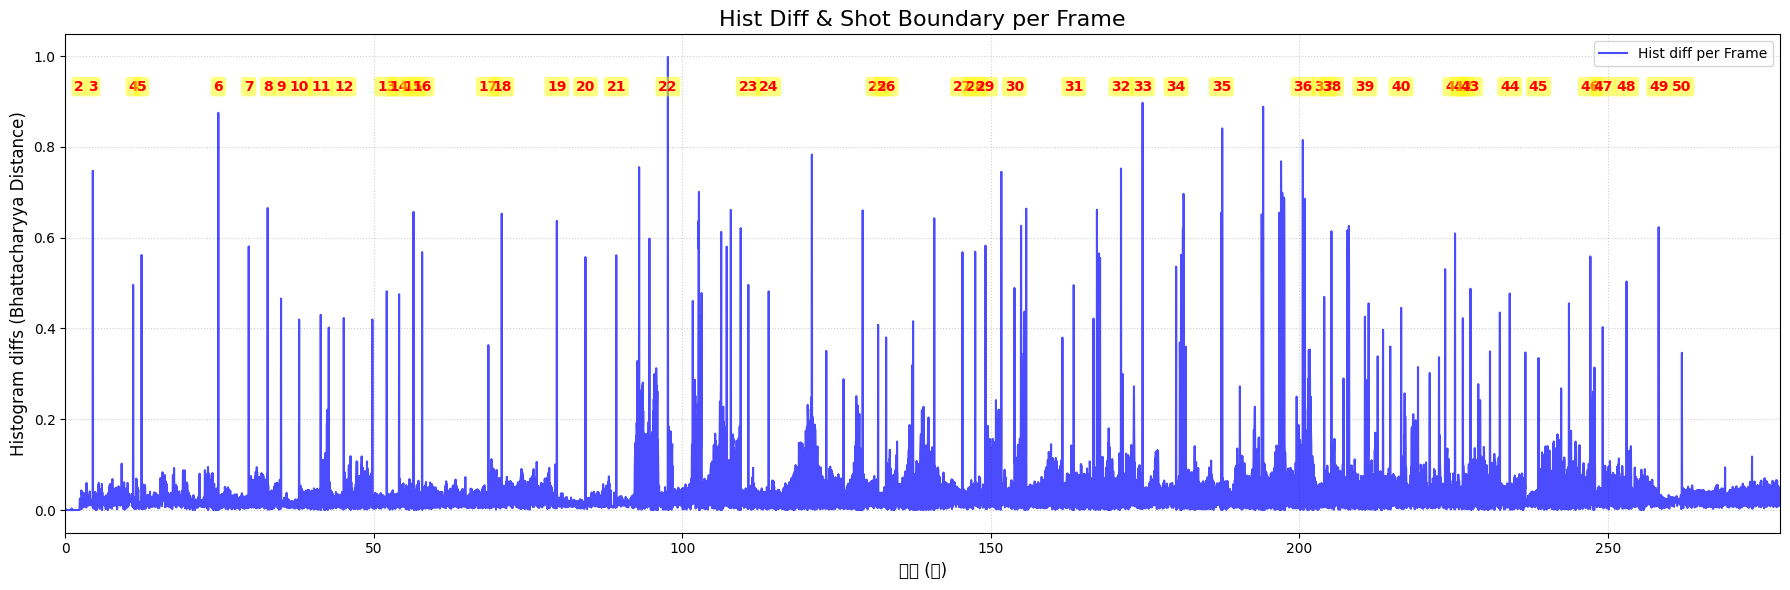

In [12]:
utils.visualize_shot_detection(diffs1, shots1, video_frame, total_frames)

In [13]:
import cv2
import numpy as np
from tqdm import tqdm

def save_with_shot_labels_720p(cap: cv2.VideoCapture, shot_boundaries, output_path="output.mp4", fps=30):
    """
    cap으로부터 전체 영상을 읽고, 샷 경계마다 "SHOT: n" 텍스트를 추가하여 720p로 저장
    """
    orig_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"🎞️ 원본 해상도: {orig_width}x{orig_height}, 총 프레임: {total_frames}")

    # 리사이즈 여부 판단 (720p 기준)
    if orig_height > 720:
        scale_ratio = 720 / orig_height
        new_width = int(orig_width * scale_ratio)
        new_height = 720
        print(f"⚠️ 해상도가 높아 720p로 리사이즈: {new_width}x{new_height}")
    else:
        new_width = orig_width
        new_height = orig_height
        print(f"✅ 리사이즈 없이 저장: {new_width}x{new_height}")

    # 출력 비디오 설정
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))

    # Shot 경계 처리용 세팅
    shot_boundaries_set = set(shot_boundaries)
    current_shot_idx = 1
    current_shot_text = f"SHOT: {current_shot_idx}"
    current_shot_color = np.random.randint(0, 256, 3).tolist()

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_thickness = 3

    with tqdm(total=total_frames, desc="💾 저장 중", unit="frame") as pbar:
        for frame_idx in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break

            # 새로운 샷이면 텍스트, 색상 갱신
            if frame_idx > 0 and frame_idx in shot_boundaries_set:
                current_shot_idx += 1
                current_shot_text = f"SHOT: {current_shot_idx}"
                current_shot_color = np.random.randint(0, 256, 3).tolist()

            # 텍스트 위치 계산
            (text_width, text_height), baseline = cv2.getTextSize(
                current_shot_text, font, font_scale, font_thickness
            )
            text_x = (orig_width - text_width) // 2
            text_y = text_height + 20

            # 텍스트 추가
            cv2.putText(
                frame,
                current_shot_text,
                (text_x, text_y),
                font,
                font_scale,
                current_shot_color,
                font_thickness,
                cv2.LINE_AA,
            )

            # 리사이즈 필요 시
            if (orig_width, orig_height) != (new_width, new_height):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)

            out.write(frame)
            pbar.update(1)

    cap.release()
    out.release()
    print(f"✅ 저장 완료: {output_path}")


30.0

In [14]:
cap = utils.openVideoStream('https://www.youtube.com/watch?v=hpXD2hwHjC8')
save_with_shot_labels_720p(cap, shots1, output_path="조커.mp4", fps=int(video_frame))

'https://www.youtube.com/watch?v=hpXD2hwHjC8'에서 progressive 720p 스트림 URL을 가져오는 중...
⚠️ 720p @30fps progressive 스트림 없음 → fallback으로 최대 해상도 progressive 선택
🎬 선택된 스트림: mp4 | 346p @ 30fps
URL: https://rr8---sn-n3cgv5qc5oq-bh2sr.googlevideo.com/videoplayback?expire=1753119842&ei=Aih-aM6DLPzw29gP_J6x-QQ&ip=163.180.118.139&id=o-ALkX5p_Y1WG_jRmQlH9qFvzOjOljF1TF9x1HkMgsDbnF&itag=18&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&met=1753098242%2C&mh=Hl&mm=31%2C26&mn=sn-n3cgv5qc5oq-bh2sr%2Csn-3pm7dnl7&ms=au%2Conr&mv=m&mvi=8&pcm2cms=yes&pl=19&rms=au%2Cau&initcwndbps=6780000&bui=AY1jyLORBFCoODBF6bais_S9gzjxB2T0W74uDhFOaiiBHdYsrySEzTvPmXky-SnXUmDCFLBb1E7HaYAX&vprv=1&svpuc=1&mime=video%2Fmp4&ns=5fAH3qtsqrUEe4EH8rvhdZ0Q&rqh=1&cnr=14&ratebypass=yes&dur=277.966&lmt=1736034760502531&mt=1753097841&fvip=3&lmw=1&fexp=51543007&c=TVHTML5&sefc=1&txp=4538434&n=TkjJDvQ197kpYg&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cbui%2Cvprv%2Csvpuc%2Cmime%2Cns%2Crqh%2Ccnr%2Cratebypass%2Cdur%2Clmt&

💾 저장 중: 100%|██████████| 8337/8337 [00:13<00:00, 635.81frame/s]

✅ 저장 완료: 조커.mp4


In [3]:
import subprocess

def mux_audio_with_video(video_path: str, audio_path: str, output_path: str):
    """
    무음 영상과 오디오를 합쳐서 하나의 mp4 파일로 저장
    :param video_path: 영상 파일 경로 (예: output.mp4)
    :param audio_path: 오디오 파일 경로 (예: audio.wav)
    :param output_path: 최종 출력 파일 경로 (예: final.mp4)
    """
    command = [
        "ffmpeg", "-y",
        "-i", video_path,
        "-i", audio_path,
        "-c:v", "copy",            # 영상은 다시 인코딩하지 않고 복사
        "-c:a", "aac",             # 오디오는 aac로 인코딩
        "-strict", "experimental",
        "-shortest",               # 영상/오디오 길이 중 짧은 쪽에 맞춤
        output_path
    ]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print(f"✅ 최종 영상 생성 완료: {output_path}")


In [ ]:
import soundfile as sf
audio, sr = utils.getAudioCroppedFromURL('https://www.youtube.com/watch?v=39O_N9llFno')
sf.write("audio.wav", audio.squeeze(), sr)

mux_audio_with_video("output_shots.mp4", "audio.wav", "final_with_audio_color_hist.mp4")

✅ 최종 영상 생성 완료: final_with_audio.mp4                      


In [11]:
cap = cv2.VideoCapture('./output_shots.mp4')